# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os.path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import anndata
import scanpy as sc
import scanpy_scripts as ss

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
ss.lib.set_figsize((4, 4))
expr_cmap = ss.lib.expression_colormap()

/home/ubuntu/miniconda/envs/scrna/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load data

In [2]:
h5ads = !ls ../data/warner20/scRNAseq_Dr_Byrd/MSG_Ni_Huang/MSG*/*.h5ad | sort -V
h5ads

['../data/warner20/scRNAseq_Dr_Byrd/MSG_Ni_Huang/MSG7/MGS7.h5ad',
 '../data/warner20/scRNAseq_Dr_Byrd/MSG_Ni_Huang/MSG8/MGS8.h5ad',
 '../data/warner20/scRNAseq_Dr_Byrd/MSG_Ni_Huang/MSG9/MGS9.h5ad',
 '../data/warner20/scRNAseq_Dr_Byrd/MSG_Ni_Huang/MSG11/MGS11.h5ad',
 '../data/warner20/scRNAseq_Dr_Byrd/MSG_Ni_Huang/MSG13/MGS13.h5ad']

In [3]:
raw_ads = [sc.read(h5ad) for h5ad in h5ads]

In [4]:
scr_dfs = [ss.lib.run_scrublet(rad, inplace=False) for rad in raw_ads]

In [5]:
for i, scr_df in enumerate(scr_dfs):
    raw_ads[i].obs['scrublet_score'] = scr_df['scrublet_score'].values
    raw_ads[i].obs['scrublet_score_z'] = scr_df['scrublet_score_z'].values
    raw_ads[i].obs['bh_pval'] = scr_df['bh_pval'].values
    raw_ads[i].obs_names = pd.Series(raw_ads[i].obs_names).str.partition('-')[0].values

In [6]:
samples = [os.path.basename(h5ad).partition('.')[0] for h5ad in h5ads]

In [7]:
raw_ad = anndata.AnnData.concatenate(*raw_ads, batch_categories=samples)

In [8]:
raw_ad.var = raw_ad.var[['gene_ids-MGS7']].rename(columns={'gene_ids-MGS7': 'gene_ids'})

In [9]:
raw_ad

AnnData object with n_obs × n_vars = 13514 × 33694 
    obs: 'batch', 'bh_pval', 'scrublet_score', 'scrublet_score_z'
    var: 'gene_ids'

In [10]:
raw_ad.write('human_salivary_gland.raw.h5ad', compression='lzf')

# Process

In [11]:
raw_ad = sc.read('human_salivary_gland.raw.h5ad')

## QC

In [12]:
ss.lib.calculate_qc(raw_ad)

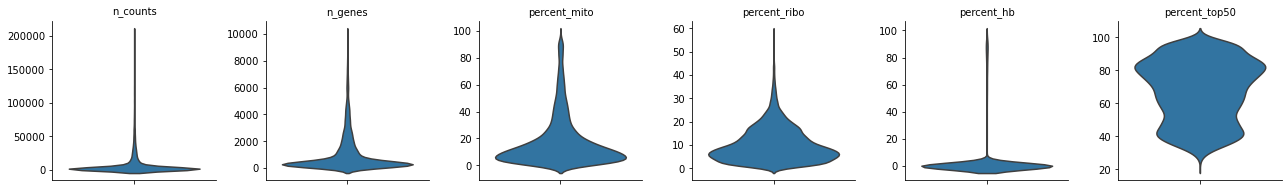

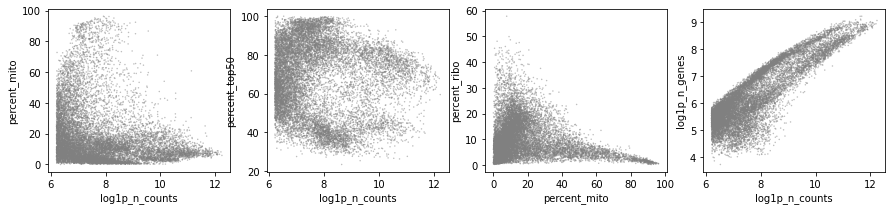

In [13]:
ss.lib.plot_qc(raw_ad)

In [14]:
raw_ad1 = ss.lib.remove_genes(raw_ad, ['mito', 'ribo'])

In [15]:
raw_ad2 = raw_ad1[raw_ad1.obs_names.isin(raw_ad1.obs.query('(n_counts > 1e3) & (n_genes>200) & (percent_mito < 30)').index.to_list())].copy()

## Cluster

In [16]:
ad1 = ss.lib.simple_default_pipeline(
    raw_ad2, post_filter_only=True, batch='batch', batch_method='bbknn', zero_center=False,
    hvg_kw={'by_batch': ('batch', 3)}, bk_kw={'n_pcs': 30, 'neighbors_within_batch': 3})

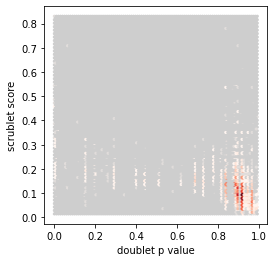

In [17]:
ss.lib.set_figsize((4, 4))
plt.hexbin(ad1.obs.bh_pval, ad1.obs.scrublet_score, cmap=expr_cmap);
plt.xlabel('doublet p value');
plt.ylabel('scrublet score');

In [18]:
ad1.obs['is_doublet'] = (ad1.obs.bh_pval < 0.6) & (ad1.obs.scrublet_score > 0.3)
ad1.obs['is_doublet'] = ad1.obs['is_doublet'].astype('category')

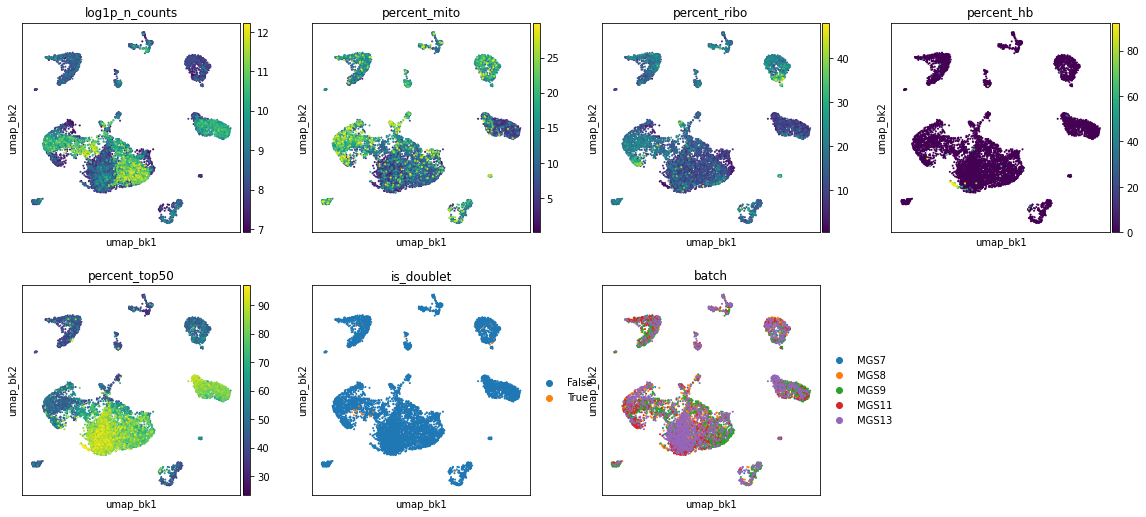

In [19]:
ss.lib.set_figsize((4, 4))
ss.lib.plot_scatter(
    ad1, basis='umap_bk',
    color=['log1p_n_counts', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'is_doublet', 'batch'], ncols=4)

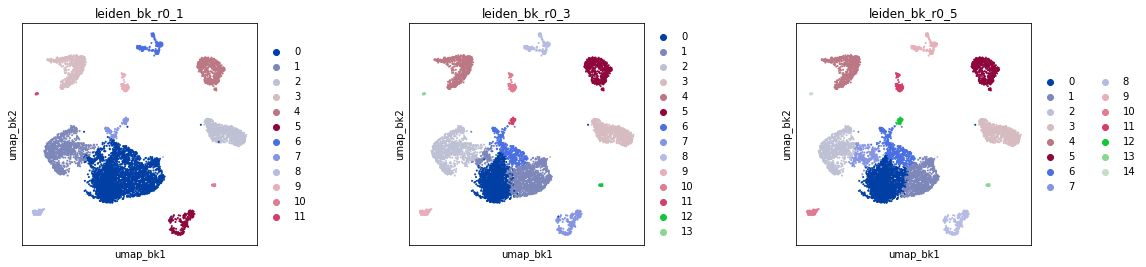

In [20]:
ss.lib.plot_scatter(ad1, basis='umap_bk', color=['leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5'], wspace=0.5)

## Annotate

In [21]:
markers = [
    'KRT15', 'PIGR', 'FOXI1', 'AIF1', 'ACTA2', 'PECAM1', 'COL3A1', 'NRXN1', 'CD3D', 'MS4A1', 'IGHA1', 'TPSB2'
]

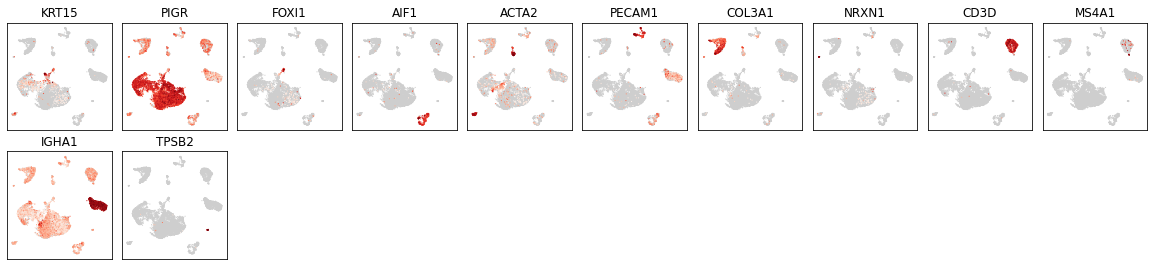

In [22]:
ss.lib.plot_genes(ad1, basis='umap_bk', genes=markers, color_map=expr_cmap, size=5);

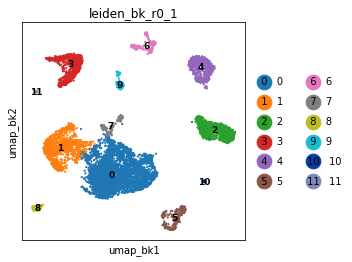

In [23]:
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_r0_1', size=20);

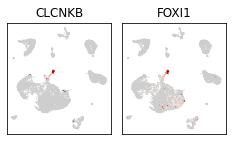

In [24]:
ss.lib.plot_genes(ad1, basis='umap_bk', genes=['CLCNKB', 'FOXI1'], color_map=expr_cmap, size=5);

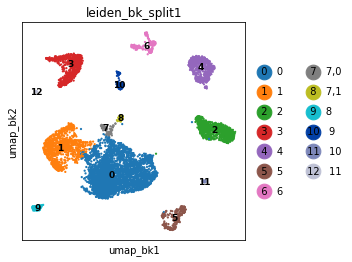

In [25]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=['leiden_bk_r0_1', ['7']], resolution=0.1, key_added='bk_split1');
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split1', size=20);

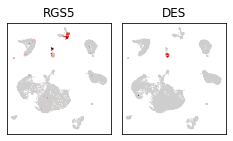

In [26]:
ss.lib.plot_genes(ad1, basis='umap_bk', genes=['RGS5', 'DES'], color_map=expr_cmap, size=5);

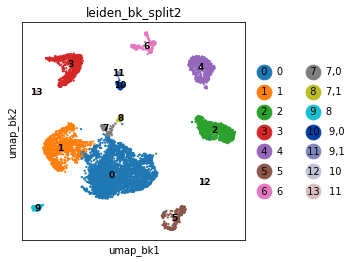

In [27]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=['leiden_bk_split1', ['9']], resolution=0.1, key_added='bk_split2');
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split2', size=20);

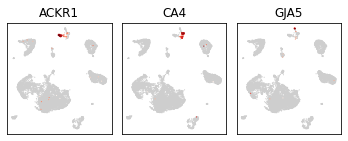

In [28]:
ss.lib.plot_genes(ad1, basis='umap_bk', genes=['ACKR1', 'CA4', 'GJA5'], color_map=expr_cmap, size=5);

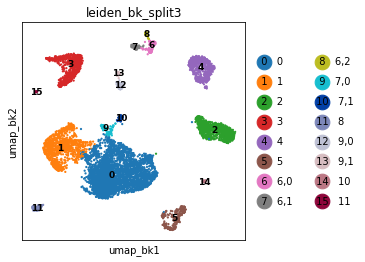

In [29]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=['leiden_bk_split2', ['6']], resolution=0.1, key_added='bk_split3');
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split3', size=20);

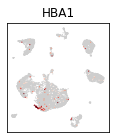

In [30]:
ss.lib.plot_genes(ad1, basis='umap_bk', genes=['HBA1'], color_map=expr_cmap, size=5);

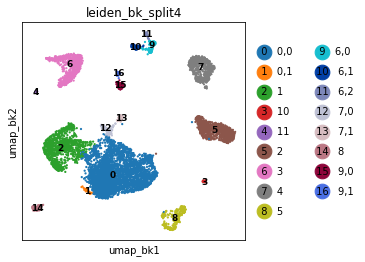

In [31]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=['leiden_bk_split3', ['0']], resolution=0.5, key_added='bk_split4');
ad1.obs['leiden_bk_split4'] = ss.lib.regroup(
    ad1, groupby='leiden_bk_split4', regroups={'0,0': ['0,0','0,1','0,2','0,3','0,4'], '0,1': '0,5'});
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split4', size=20);

In [32]:
t_ad = ad1[ad1.obs.leiden_bk_split1=='4'].copy()

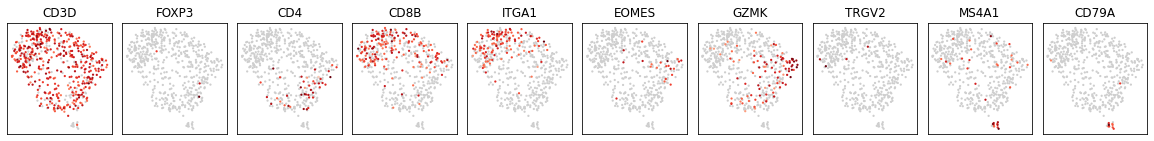

In [33]:
im_markers = ['CD3D', 'FOXP3', 'CD4', 'CD8B', 'ITGA1', 'EOMES', 'GZMK', 'TRGV2', 'MS4A1', 'CD79A']
ss.lib.plot_genes(t_ad, basis='umap_bk', genes=im_markers, color_map=expr_cmap, size=20);

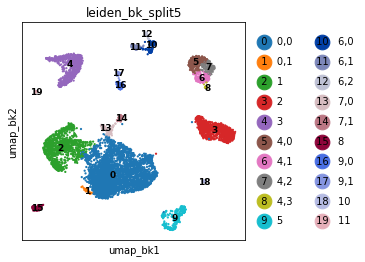

In [34]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=['leiden_bk_split4', ['4']], resolution=0.35, key_added='bk_split5');
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split5', size=20);

In [35]:
myl_ad = ad1[ad1.obs.leiden_bk_split1=='5'].copy()

In [36]:
myeloid_markers = [
    'C1QA', 'FOLR2', 'CLEC9A', 'CLEC10A', 'LAMP3', 'CD207', 'FCGR3A']

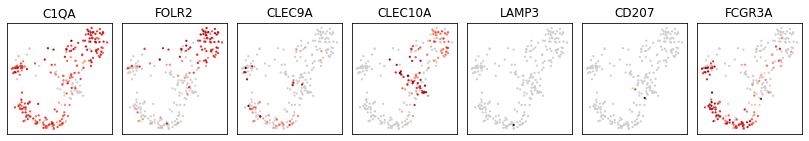

In [37]:
ss.lib.plot_genes(myl_ad, basis='umap_bk', genes=myeloid_markers, color_map=expr_cmap, size=20);

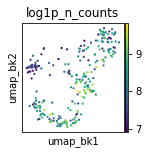

In [38]:
ss.lib.plot_scatter(myl_ad, basis='umap_bk', color='log1p_n_counts', size=20);

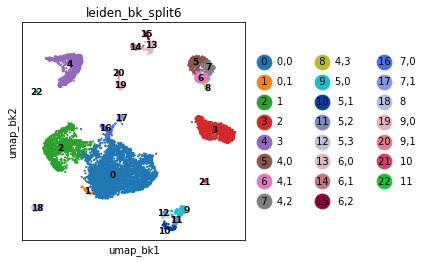

In [39]:
ss.lib.leiden(ad1, use_graph='neighbors_bk', restrict_to=['leiden_bk_split5', ['5']], resolution=0.5, key_added='bk_split6');
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split6', size=20);

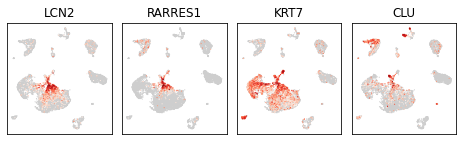

In [40]:
ss.lib.plot_genes(ad1, basis='umap_bk', genes=['LCN2', 'RARRES1', 'KRT7', 'CLU'], color_map=expr_cmap, size=5, vmin=1)

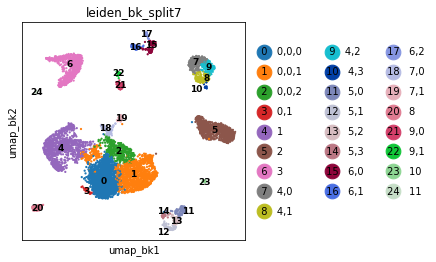

In [41]:
ss.lib.leiden(ad1, resolution=0.2, use_graph='neighbors_bk', restrict_to=('leiden_bk_split6', ['0,0']), key_added='bk_split7')
ss.lib.plot_embedding(ad1, basis='umap_bk', groupby='leiden_bk_split7', size=20);

In [42]:
ad1.obs['annot1'] = ss.lib.regroup(ad1, groupby='leiden_bk_split7', regroups={
    'Th': '4,1',
    'Tc 1': '4,2',
    'Tc 2': '4,0',
    'B': '4,3',
    'Plasma': '2',
    'Mac 1': '5,0',
    'Mac 2': '5,1',
    'DC2': '5,2',
    'Mast': '10',
    'VE ven': '6,1',
    'VE cap': '6,0',
    'VE art': '6,2',
    'Ionocytes': '7,1',
    'Basal': '7,0',
    'Duct': '0,0,2',
    'Serous Acini': ['0,0,0', '0,0,1'],
    'Mucous Acini': '1',
    'Duct': '0,0,2',
    'Myoepi': '8',
    'SM': '9,0',
    'PC': '9,1',
    'Glia': '11',
    'Fibroblasts': '3',
    'Erythrocytes': '0,1',
    'Low quality': '5,3'
})

In [43]:
ad2 = ad1[(ad1.obs.annot1!='Low quality') & (~ad1.obs.is_doublet.astype(bool))].copy()

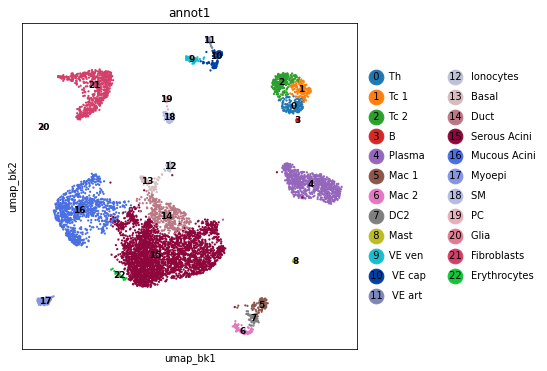

In [44]:
ss.lib.plot_embedding(ad2, basis='umap_bk', groupby='annot1', size=20, figsize=(6, 6));

In [45]:
ad2.write('human_salivary_gland.processed.h5ad', compression='gzip')

## Markers

In [46]:
mkst = ss.lib.calc_marker_stats(ad2, groupby='annot1')

In [47]:
mks = ss.lib.filter_marker_stats(mkst[2], max_next_frac=0.45, how='and', single=False)

In [48]:
deg = ss.lib.test_markers(ad2, mks, groupby='annot1')

In [49]:
deg1 = deg.loc[lambda x: x.pvals < 0.01].copy()

In [50]:
deg1s = deg1.groupby('cluster', sort=False).apply(lambda x: x.sort_values(['frac_diff', 'pvals_adj'], ascending=[False, True])).reset_index(drop=True)

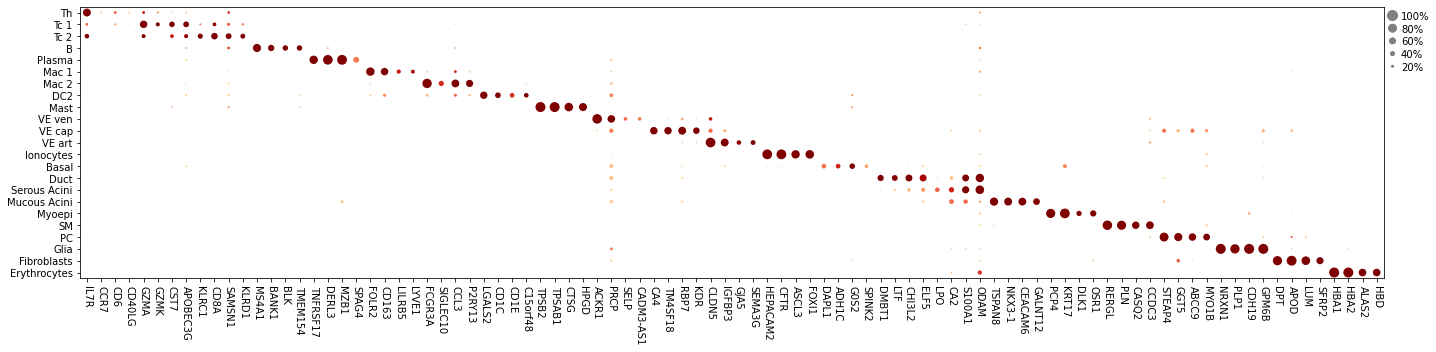

In [51]:
ss.lib.dotplot2(ad2, deg1s.groupby('cluster', sort=False).head(4).genes.to_list(), groupby='annot1', color_map='OrRd', swap_axis=True);

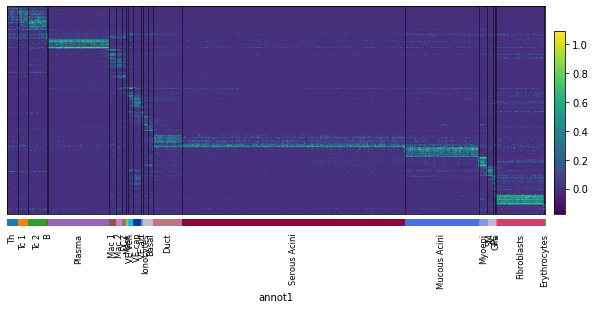

In [52]:
sc.pl.heatmap(ad2, deg1s.groupby('cluster', sort=False).head(10).genes.to_list(), groupby='annot1', standard_scale='var', swap_axes=True);

## SARS-CoV-2 entry factors

In [53]:
covid_markers_human = [
    'ACE2', 'TMPRSS2', 'BSG', 'TFRC', 'CTSL', 'CTSB', 'TMPRSS4', 'TMPRSS11D', 'LY6E',
    'IFITM1', 'IFITM2', 'IFITM3', 'GSK3', 'HNRNPA1', 'FURIN', 'DDX3X', 'MADP1', 'TOP3B',
    'DPP4', 'STGAL4', 'ST3GAL1', 'ST14', 'ANPEP', 'VCP', 'FIIT1', 'IFIT2', 'IFIT3', 'CDHR3',
    'CD209', 'CLEC4G', 'CLEC4M', 'CHMP2A', 'ORF98', 'AP2A2', 'AP2M1', 'TAPT1', 'RHOA',
    'RAB14', 'RAB10', 'NSP7', 'RAB1A', 'ZCRB1'
]

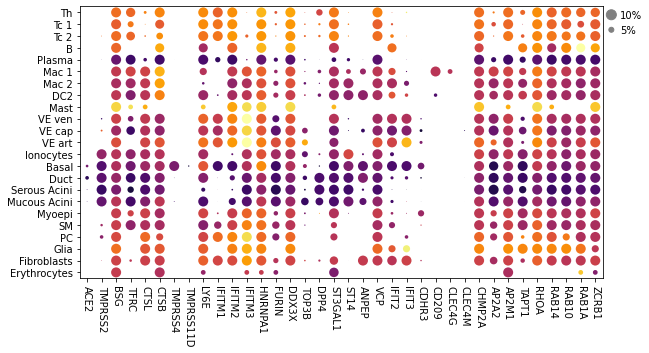

In [54]:
ss.lib.dotplot2(
    ad2, [g for g in covid_markers_human if g in ad2.raw.var_names], groupby='annot1',
    vmin=0, vmax=3, mean_only_expressed=True, dot_max=0.1, color_map='inferno', swap_axis=True,
);